###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

**NOTE:** Do not modify any of the cells (with code) provided in this notebook or you might have problems finishing the assignment.

## Part I - Motivation
Up to this point we have implemented relatively simple algorithms where we can compute the objective function $J(w)$ and its gradient $\nabla J(w)$ on paper and then implement it. For more complex computations such as the back-propagation method for neural networks or the softmax classifier cost and gradient (topic of this assignment), it can be notoriously more difficult to get right and of course debug. Suprisingly sometimes we can learn good performing models even with a buggy implementation and we won't notice we have a mistake in our implementation by just looking at the performance. To deal with these situations we could implement a gradient check computation, which approximates the gradient numerically and compares to that computed using the formulas derived analytically.

### Gradient check

#### Intuition

Recall the definition of directional derivative of $J(w)$ in the direction of some vector $\vec{\epsilon}$ is:

\begin{align}
\frac{\partial}{\partial \vec{\epsilon}}J(w) = \lim_{h \rightarrow 0}
\frac{J(w + h\vec{\epsilon}) - J(w - h\vec{\epsilon})}{2h{\lVert\vec{\epsilon}\rVert}} = {\nabla J(w)}^T \cdot \vec{\epsilon}\label{eq1}\tag{1}
\end{align}

We could approximate this derivative by manually selecting a small value for $h$, for instance $10^{-4}$ and choosing $\vec{\epsilon}$ as shown below.

\begin{align}
\vec{\epsilon} = \begin{bmatrix}0 & 0 & \dots & 1 & \dots & 0\end{bmatrix}^{T}\label{eq2}\tag{2}
\end{align}

There are many possible values for $h$, but we should not pick $h$ to be “extremely” small, say $10^{−20}$, as that would lead to numerical roundoff errors.

Given our definition of $\vec{\epsilon}$ and $h$ we could say that:

\begin{align}
\frac{\partial}{\partial \vec{\epsilon}}J(w) \approx \frac{J(w + h\vec{\epsilon}) - J(w -h\vec{\epsilon})}{2h\lVert\vec{\epsilon}\rVert} = \frac{J(w + h\vec{\epsilon}) - J(w -h\vec{\epsilon})}{2h}\label{eq3}\tag{3}
\end{align}

Now, from the definition of the partial derivative given in ([1](#mjx-eqn-eq1)) and our vector $\vec{\epsilon}$ given in ([2](#mjx-eqn-eq2)) we get that:

\begin{align}
\frac{\partial}{\partial \vec{\epsilon}}J(w) = {\nabla J(w)}^T \cdot \vec{\epsilon} = \frac{\partial}{\partial w_j}J(w)\label{eq4}\tag{4}
\end{align}

This means we are approximating the partial derivative of our cost function with respect to a small change only in the weight $w_j$, and therfore the following relationship should hold:

\begin{align}
\frac{\partial}{\partial w_j}J(w) \approx \frac{J(w + h\vec{\epsilon}) - J(w -h\vec{\epsilon})}{2h}\label{eq5}\tag{5}
\end{align}

In other words, the $j$ component of our gradient should be approximately equal to our approximation of the partial derivative.

Notice that if $J$ depends only on $w_0$ and $w_1$, that is $J(w_0,w_1)$ we could rewrite ([5](#mjx-eqn-eq5)) as:

\begin{align}
\frac{\partial}{\partial w_0}J(w_0,w_1) \approx \frac{J(w_0 + h,w_1) - J(w_0 - h,w_1)}{2h}\label{eq6}\tag{6}
\end{align}

\begin{align}
\frac{\partial}{\partial w_1}J(w_0,w_1) \approx \frac{J(w_0,w_1+h) - J(w_0,w_1-h)}{2h}\label{eq7}\tag{7}
\end{align}

#### The actual check...
So at each iteration in our gradient descend implementation, once we compute $\nabla J(w)$ analytically, we could check the previous relationship holds for some random values of $j$. Of course we will need some acceptable threshold to consider they are approximally equal. Usually you could find that both quantities will agree to at least four or more significant digits.

## Part II - Setting up libraries & utility functions
Do not modify anything on this section

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as alg
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
import math

In [2]:
# Do not modify or delete this!
def plot_boundary(predict,predict_proba,
                  w,X_train,y_train,X_test,y_test,
                  poly=None,scaler=None,xlim=(0,1),ylim=(0,1)):
    # Generates mesh
    pts = 100
    x1 = np.linspace(xlim[0], xlim[1], pts)  # x1
    x2 = np.linspace(ylim[0], ylim[1], pts)  # x2
    x1, x2 = np.meshgrid(x1, x2)
    mesh = np.vstack((x1.flatten(), x2.flatten())).T
    if poly is not None:
        mesh = poly.transform(mesh)
    if scaler is not None:
        mesh[:,1:] = scaler.transform(mesh[:,1:])    
    # Training set
    if scaler is not None:
        temp = scaler.inverse_transform(X_train[:,1:])
    plt.scatter(temp[:,0],temp[:,1],cmap='viridis',c=y_train,s=50,edgecolor='k')
    # Boundary
    h = predict_proba(w,mesh)
    indexes = set(range(h.shape[1]))
    for i in indexes:
        g = h[:,i] - h[:,list(indexes - {i})].max(axis=1)
        plt.contour(x1, x2, g.reshape((pts,pts)), levels = [0], colors='black')
    # Decision regions
    y_pred = predict(w,mesh).reshape((pts,pts))
    plt.contourf(x1, x2, y_pred, alpha = 0.10,cmap='viridis')
    # Test set
    y_pred = predict(w,X_test)
    correct = (y_pred == y_test)
    if scaler is not None:
        temp = scaler.inverse_transform(X_test[:,1:])
    plt.scatter(temp[correct,0],temp[correct,1], marker='.', c='black', s=60)
    plt.scatter(temp[~correct,0],temp[~correct,1], marker='x', c='black', s=60)

def compute_metrics(predict,w,X_train,y_train,X_test,y_test,threshold=0.5):
    # trainig metrics
    y_pred = predict(w,X_train)
    print('Training Metrics:')
    print('Accuracy: ', '%.2f'  % accuracy_score(y_train, y_pred))
    print('F1 Score: ', '%.2f'  % f1_score(y_train, y_pred, average='macro'))
    print('Recall: ', '%.2f'  % recall_score(y_train, y_pred, average='macro'))
    print('Precision: ', '%.2f'  % precision_score(y_train, y_pred, average='macro'))
    y_pred = predict(w,X_test)
    print('\nTest Metrics:')
    print('Accuracy: ', '%.2f'  % accuracy_score(y_test, y_pred))
    print('F1 Score: ', '%.2f'  % f1_score(y_test, y_pred, average='macro'))
    print('Recall: ', '%.2f'  % recall_score(y_test, y_pred, average='macro'))
    print('Precision: ', '%.2f'  % precision_score(y_test, y_pred, average='macro'))

## Part III - Simple gradient check
In this part you will implement a function to check the gradient of a simple function with only two dependant variables.

Below you can find the analytical definition of some cost function `cost`:

\begin{align}
\text{cost}(w_0,w_1)=\text{sin}(w_0) + \text{cos}(w_1)\label{eq8}\tag{8}
\end{align}

Notice `cost` depends on two variables $w_0$ and $w_1$

In [3]:
# Implementation of cost. Do not modify or delete this!
def cost(w0,w1):
    return np.sin(w0) + np.cos(w1)

In [4]:
# Building mesh. Do not modify or delete this!
pts = 50
w0 = np.linspace(-4,4,pts)
w1 = np.linspace(-4,4,pts)
[w0,w1] = np.meshgrid(w0,w1)

Text(0.5, 0, 'w1')

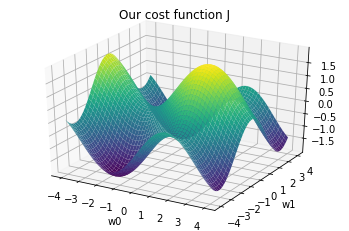

In [5]:
# Plotting function. Do not modify or delete this!
J = cost(w0,w1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(w0,w1,J,cmap='viridis')
ax.set_title('Our cost function J')
ax.set_xlabel('w0')
ax.set_ylabel('w1')

### 1. Question
Given the analytical  definition of the function `cost` in ([6](#mjx-eqn-eq6)):
* Generate two random floating-point numbers between -4 and 4 and store them in two variables named `w0` and `w1`.
* Determine the gradient of the function `cost` at the point `w0`,`w1`
* Store each component of the gradient (computed analytically) in two variables named `g0` and `g1`, respectively.

In [6]:
w0 = np.random.uniform(-4, 4)
w1 = np.random.uniform(-4, 4)
if w0 == w1:
    while w0 == w1:
        w1 = np.random.uniform(-4, 4)
g0 = np.cos(w0)
g1 = (-1) * np.sin(w1)

### 2. Question
We are going to implement a function to check the gradient we computed before.

Define a function (python) named `check_gradient` that receives the following arguments:
* `func`: A callable (function in python) that evaluates the function we are computing the gradient of (in this case you can simply pass `cost`).
* `w0`: Value of the first dependant variable of the function `func`.
* `w1`: Value of the second dependant variable of the function `func`.
* `g0`: First component of the gradient of `func` (computed analytically), that is the partial derivative of `func` with respect to the first dependant variable.
* `g1`: Second component of the gradient of `func` (computed analytically), that is the partial derivative of `func` with respect to the first dependant variable.

The function `check_gradient` should approximate the gradient of `func` using the idea describe above, and compare to that provided to the function through the arguments `g0` and `g1`. As you can infer, you can check each component separately. You will consider each component of the gradient is correctly computed if is equal to your approximation by at least 4 significant digits. You can use a step $h=10^{-4}$.

Your `check_gradient` implementation should output the following (try to follow the format):

Checking df/dx - Analytical: `###`, Approx: `###` (`Passed`)<br>
Checking df/dy - Analytical: `###`, Approx: `###` (`Passed`)

`###` should be filled up with the proper values<br>
`Passed` should only be printed out if the test passed, otherwise output `Failed`

In [7]:
def check_gradient(cost, w0, w1, g0, g1):
    h = 1e-4
    check_w0 = (cost(w0 + h, w1) - cost(w0 - h, w1)) / (2 * h)
    check_w1 = (cost(w0, w1 + h) - cost(w0, w1 - h)) / (2 * h)
    outcome = True
    outcome_w0 = outcome & ((g0 - check_w0) < 1e-4)
    outcome_w1 = outcome & ((g1 - check_w1) < 1e-4)
    if outcome_w0:
        print('Checking df/dx - Analytical:  ', g0, ', Approx: ', check_w0, ' (Passed)')
    else:
        print('Checking df/dx - Analytical:  ', g0, ', Approx: ', check_w0, ' (Failed)')
    if outcome_w1:
        print('Checking df/dy - Analytical:  ', g1, ', Approx: ', check_w1, ' (Passed)')
    else:
        print('Checking df/dy - Analytical:  ', g1, ', Approx: ', check_w1, ' (Failed)')

#### Unit test (Q2)
If your implementation is correct, the function call in the cell below will produce the expected output where all tests will pass.

In [8]:
# Builds unit test. Do not modify this cell!
def unit_test(w0,w1,g0,g1):
    check_gradient(cost,w0,w1,g0,g1)
unit_test(w0,w1,g0,g1)

Checking df/dx - Analytical:   -0.8518249012508692 , Approx:  -0.8518248998329314  (Passed)
Checking df/dy - Analytical:   -0.9677267160204317 , Approx:  -0.9677267144073132  (Passed)


#### Unit test (Q2)

If your implementation is correct, the function call in the cell below will produce the expected output where only the second test will pass.

In [9]:
# Builds unit test. Do not modify this cell!
def unit_test(w0,w1,g0,g1):
    g0 = g0 + 0.01
    check_gradient(cost,w0,w1,g0,g1)
unit_test(w0,w1,g0,g1)

Checking df/dx - Analytical:   -0.8418249012508692 , Approx:  -0.8518248998329314  (Failed)
Checking df/dy - Analytical:   -0.9677267160204317 , Approx:  -0.9677267144073132  (Passed)


## Part IV - General implementation for gradient check
**Here you will implement a gradient check function that can handle gradients of more than two components.** You will randomly check only some of those components for validity. For this you will be given an implementation of grandient descend for a logistic regression classifier with l2 regularization using Newton's method. Your main goal will be to implement a function to check the gradient computation at every iteration of the algorithm.

Guidelines:

* First, understand the code given to you.
* Do not modify any of the given code.
* Verify you pass the unit tests!

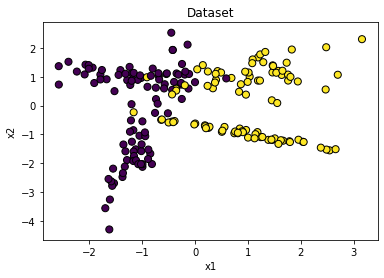

In [10]:
# Generating dataset. Do not modify this cell!
obs = 200
X, y = make_classification(n_samples=obs, n_features=2, n_redundant=0, n_informative=2)
plt.title('Dataset')
plt.scatter(X[:,0], X[:,1], marker='o', c=y.flatten(), s=50, edgecolor='k',cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
# Splits into training/test sets
X_train, X_test, y_train, y_test = train_test_split(X,y)
# Expand dataset to include polynomial features
d = 7
ps = PolynomialFeatures(degree = d)
ps.fit(X_train)
X_train = ps.transform(X_train)
X_test = ps.transform(X_test)
# Standarize dataset
sc = StandardScaler()
sc.fit(X_train[:,1:])
X_train[:,1:] = sc.transform(X_train[:,1:])
X_test[:,1:] = sc.transform(X_test[:,1:])

In [11]:
# Do not modify this cell!
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [12]:
# Do not modify this cell!
def predict_proba(w,X):
    h = sigmoid(X.dot(w))
    return np.vstack((1-h,h)).T

In [13]:
# Do not modify this cell!
def predict(w,X):
    return predict_proba(w,X).argmax(axis=1)

In [14]:
# Do not modify this cell! (this provides the cost computation)
def compute_cost(w,X,y,reg):
    h = sigmoid(X.dot(w))
    loglikelihood = sum([np.log(prob) if label else np.log(1-prob) for prob,label in zip(h,y)]) 
    loglikelihood -= reg*(w[1:]**2).sum()
    return -loglikelihood

In [15]:
# Do not modify this cell! (here is the call to check_gradient)
def compute_grad(w,X,y,reg):
    h = sigmoid(X.dot(w))
    grad = (X.T).dot(h - y) + np.concatenate(([0],2*reg*w[1:]))
    check_gradient(compute_cost,w,grad,args=(X,y,reg),checks=10)
    return grad

### 3. Question

You must implement a function named `check_gradient` using the ideas explained above from ([1](#mjx-eqn-eq1)) to ([5](#mjx-eqn-eq5)). Your function must do the following:
* Receives and uses the following arguments:
    1. A callable `func` that represents the python function that computes and returns the cost.
    2. A vector `w` representing the current parameters (all of them) where we are computing/checking the gradient.
    3. A vector `grad` containing the gradient computation using the formulas derived analytically. It must have the same size as `w`.
    4. A tuple `args` that contains all extra arguments you want to send to the function `func`. You can unpack all arguments in `args` and send it to a function using `*args`. Read [here](https://www.geeksforgeeks.org/packing-and-unpacking-arguments-in-python/) for more details.
    5. A integer `checks` representing how many components of the gradient you need to check inside the function. By default this should be 10.
    6. A integer `threshold` representing the acceptable difference between both gradient computations. By default this should be 1e-5 (four significant digits difference).
* Performs the following:
    * Randomly verifies `checks` number of components of the gradient vector using the ideas explained above from ([1](#mjx-eqn-eq1)) to ([5](#mjx-eqn-eq5)). The selection of what components to check should be random!
    * Assumes the gradient component of the analytical computation is correct if is close to the numerical approximation by at least `threshold`.
    * Prints out a message, as in the unit tests shown below, if the gradient component is incorrect.

In [16]:
def check_gradient(cost, w, grad, args, checks=10, threshold=1e-5):
    num_variables = len(grad)
    if checks > num_variables:
        checks = num_variables
    rand_components = np.sort(random.sample(range(0, num_variables), checks))
    h = 1e-4

    m, d = args[0].shape
    w = w.reshape(d, -1)
    d, n = w.shape

    index_array = np.arange(0, num_variables).reshape(d, n)
    approximate_grad = np.array([[0] * num_variables] * 1).reshape(d, n).astype('float64')
    for i in rand_components:
        selected_component = np.where(index_array == i)
        epsilon = np.array([[np.nan] * w.shape[1]] * w.shape[0])
        epsilon[selected_component[0], selected_component[1]] = 1
        epsilon = np.nan_to_num(epsilon)        
        approximate_grad[selected_component[0], selected_component[1]] = (compute_cost((w + (h * epsilon)).astype('float64'), args[0], args[1],
                                               args[2]) - compute_cost((w - (h * epsilon)).astype('float64'),
                                                                       args[0], args[1], args[2])) / (2 * h)

    if n > 1:
        approximate_grad = approximate_grad.flatten()[rand_components].reshape(checks, 1)
    else:
        approximate_grad = approximate_grad[rand_components]
    analytical_grad = grad[rand_components].reshape(approximate_grad.shape[0], approximate_grad.shape[1])

    outcome = True
    outcome_w = outcome & (abs(analytical_grad - approximate_grad) < threshold)
    for i in list(range(checks)):
        if outcome_w[i] == False:
            print('Wrong Entry ', i, ' - Analytical: ', analytical_grad[i].astype('float64'), ', Approx: ',
                  approximate_grad[i].astype('float64'))

#### Unit test (Q3)

If your implementation is correct, the function call in the cell below should produce the following result:
<br>
<br>
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">
Wrong entry 1 - Analytical: 22.37727962993173, Approx: 22.39158339335745<br>
Wrong entry 3 - Analytical: 52.25914586860823, Approx: 52.27004345790931<br>
Wrong entry 4 - Analytical: 18.663581697965416, Approx: 18.672054783479552<br>
Wrong entry 2 - Analytical: -65.79802249370802, Approx: -65.78596725198338
</span>

**Notice entry 0 is not incorrect!** (Ask yourself why - Take a look at the unit test code!)

In [17]:
# Builds unit test. Do not modify this cell!
def unit_test():
    d = 5
    X, y = make_classification(n_samples=obs, n_features=d, n_redundant=0, n_informative=2, random_state=0)
    rnd.seed(0)
    w = rnd.rand(d)
    h = sigmoid(X.dot(w))
    reg = 1e-2
    grad = (X.T).dot(h - y)
    check_gradient(compute_cost,w,grad,args=(X,y,reg),checks=d)
unit_test()

Wrong Entry  1  - Analytical:  [22.37727963] , Approx:  [22.39158339]
Wrong Entry  2  - Analytical:  [-65.79802249] , Approx:  [-65.78596725]
Wrong Entry  3  - Analytical:  [52.25914587] , Approx:  [52.27004346]
Wrong Entry  4  - Analytical:  [18.6635817] , Approx:  [18.67205478]


#### Unit test (Q3)
If your implementation is correct, the cells below will produce a boundary plot and performance metric chart with very few, if not none, incorrect gradient computations. The number of wrong computations might change from run to run since there is a random factor involved. Also the difference between both computation should not be that big!

In [18]:
# Solves for w using L-BFGS-B (quasi newtown's method). Do not modify this cell!
reg = 1e-2
_,d = X_train.shape
w0 = rnd.rand(d)
op = {'gtol': 1e-8}
result = opt.minimize(compute_cost, w0, method = 'L-BFGS-B',
                      jac = compute_grad, 
                      args = (X_train,y_train,reg), 
                      options = op)
w = result.x
print('Training finished after {:} iterations'.format(result.nit))

Training finished after 68 iterations


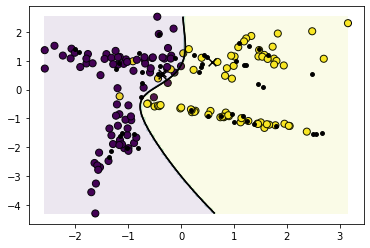

In [19]:
# Plots boundary and cost. Do not modify this cell!
plot_boundary(predict, predict_proba,
              w,X_train,y_train,X_test,y_test,
              poly=ps,scaler=sc,
              xlim=(X[:,0].min(), X[:,0].max()),
              ylim=(X[:,1].min(), X[:,1].max()))

In [20]:
# Computes metrics. Do not modify this cell!
compute_metrics(predict,w,X_train,y_train,X_test,y_test)

Training Metrics:
Accuracy:  0.95
F1 Score:  0.95
Recall:  0.95
Precision:  0.95

Test Metrics:
Accuracy:  0.94
F1 Score:  0.94
Recall:  0.94
Precision:  0.94


## Part V - Gradient check for a sofmax classifier
Here you will implementing the training of a softmax regressor using the optimization toolbox from python as we did before for logistic regression. You will be given a dataset of three classes and two features, expanded using polynomial features. Your main goal is to implement all necessary functions (with the requested signature) to interact with the provided code. Briefly, the necessary functions are:
1. `softmax`: computes the softmax function of every row vector in a given matrix
2. `predict_proba`: determines the probability per class of all observations in the provided data matrix.
3. `predict`: determines the class of all observations in the provided data matrix.
4. `compute_cost`: computes the cost for a softmax classifier given the current weights.
5. `compute_grad`: computes the gradient of the cost function for a softmax classifier given the current weights.
6. `check_gradient`: checks the gradient as specified before; you could use here your implementation from previous section.

Notice that the main goal of the `check_gradient` implementation in previous section is to have that function used here as well. If this happens to be too challenging, you can redefine it so it interfaces with your other functions defined in this part.

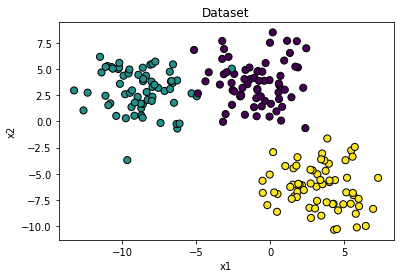

In [21]:
# Generating dataset. Do not modify this cell!
obs = 200
n = 3
X, y = make_blobs(n_samples=obs,centers=n,n_features=2,cluster_std=2.0)
plt.scatter(X[:,0], X[:,1], marker='o', c=y, s=50, edgecolor='k',cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Dataset')
# Splits into training/test sets
X_train, X_test, y_train, y_test = train_test_split(X,y)
# Expand dataset to include polynomial features
d = 7
ps = PolynomialFeatures(degree = d)
ps.fit(X_train)
X_train = ps.transform(X_train)
X_test = ps.transform(X_test)
# Standarize dataset
sc = StandardScaler()
sc.fit(X_train[:,1:])
X_train[:,1:] = sc.transform(X_train[:,1:])
X_test[:,1:] = sc.transform(X_test[:,1:])

### 4. Question

Define a function named `softmax` following these constraints:
* Receives a matrix.
* Computes the softmax function for each row in the input matrix and returns the resulting matrix. Notice the sum of each row in the resulting matrix should add up to one.

In [22]:
def softmax(X):
    num_columns = len(X[0, :])
    num_rows = len(X[:, 0])
    softmax = np.array([[None] * num_columns] * num_rows)
    for i in list(range(num_rows)):
        row_exp = np.array([[None] * num_columns] * 1)
        for j in list(range(num_columns)):
            row_exp[0, j] = math.exp(X[i, j])
        softmax[i, :] = row_exp/sum(row_exp[0,:])
    return softmax

#### Unit test (Q4)
The following unit test should outputs `True`

In [23]:
# Builds unit test. Do not modify this cell!
def unit_test():
    rnd.seed(0)
    X = rnd.randn(10,5)
    return (abs(softmax(X).sum(axis=1) - 1) < 1e-5).all()
unit_test()

True

### 5. Question

Define a function named `predict_proba` following these constraints:
* Receives a data matrix of `m` (observations) by `d` (features).
* Receives a weight matrix of `d` (features) by `n` (classes)
* Computes the probability of each observation of belonging to each class assuming a softmax regressor of parameters specified by the weight matrix. Notice the sum of each row in the resulting matrix should add up to one.

In [24]:
def predict_proba(W, X):
    h = softmax(X.dot(W))
    return h

#### Unit test (Q5)
The following unit test should outputs `True`

In [25]:
# Builds unit test. Do not modify this cell!
def unit_test():
    rnd.seed(0)
    X = rnd.rand(10,5)
    W = rnd.randn(5,3)
    return (abs(predict_proba(W,X).sum(axis=1) - 1) < 1e-5).all()
unit_test()

True

### 6. Question

Define a function named `predict` following these constraints:
* Receives a data matrix of `m` (observations) by `d` (features).
* Receives a weight matrix of `d` (features) by `n` (classes)
* Determines the class of each observation (where 0 corresponds to the first class and n-1 to the last class).
* Outputs the corresponding vector of `m` elements.

In [26]:
def predict(W, X):
    probabilities = predict_proba(W, X)
    classes = np.argmax(probabilities, axis=1)
    return classes

#### Unit test (Q6)
The following unit test should output:
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">    
array([0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2], dtype=int64)
</span>

In [27]:
# Builds unit test. Do not modify this cell!
def unit_test():
    rnd.seed(15)
    X = rnd.rand(15,6)
    W = rnd.randn(6,3)
    return predict(W,X)
unit_test()

array([0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2], dtype=int64)

### 7. Question

Define a function named `compute_cost` to compute the cost function of a softmax classifier with l2 regularization following these constraints:
* Receives a weight vector of `d*n` components. This is the original weight matrix flatten out. We do this since the minimize function treats all parameters on a single vector.
* Receives a data matrix of `m` (observations) by `d` (features).
* Receives the output vector of `m` elements, representing the class of each observation. These values range from 0 to n-1.
* Receives the regularization parameter lambda.

In [28]:
def compute_cost(W, X, y, reg):
    m, d = X.shape
    W = W.reshape(d, -1)
    d, n = W.shape
    h = predict_proba(W, X)

    first_term = 0
    for i in list(range(m)):
        for j in list(range(n)):
            y_ck = (y[i] == j).astype('int')
            loglikelihood = np.log(h[i, j])
            first_term += y_ck * loglikelihood

    second_term = 0
    for i in list(range(d))[1:]:
        for j in list(range(n)):
            second_term += (W[i, j] ** 2)

    cost = -first_term + (reg * second_term)

    return cost

#### Unit test (Q7)
The following unit test should output `16.498707556671526`

In [29]:
# Builds unit test. Do not modify this cell!
def unit_test():
    rnd.seed(20)
    X = rnd.rand(15,6)
    W = rnd.randn(6,3)
    y = rnd.randint(0,2,(15,))
    reg = 1e-2
    return compute_cost(W.flatten(),X,y,reg)
unit_test()

16.498707556671523

### 8. Question

Define a function named `compute_grad` to compute the gradient of the cost function of a softmax classifier with l2 regularization following these constraints:
* Receives a weight vector of `d*n` components. This is the original weight matrix flatten out. We do this since the minimize function treats all parameters on a single vector.
* Receives a data matrix of `m` (observations) by `d` (features).
* Receives the output vector of `m` elements, representing the class of each observation. These values range from 0 to n-1.
* Receives the regularization parameter lambda.
* Computes the gradient of the cost function.
* Checks the gradient computation (of 10 components each time).
* Returns the gradient as a vector of `d*n` components.

In [30]:
def compute_grad(W,X,y,reg):
    m,d = X.shape
    W = W.reshape(d, -1)
    d,n = W.shape
    h = predict_proba(W, X)

    gradient = (np.array([[0] * (n)] * d)).astype('float64')
    for l in list(range(n)):
        first_term  = (np.array([[0] * (d)] * 1)).astype('float64')
        for i in list(range(m)):
            y_lk = (y[i] == l).astype('int')
            S_n_lk = h[i, l]
            X_k = X[i, :]
            first_term += (y_lk - S_n_lk) * X_k
        second_term = (2 * reg * (np.array([0] + list(W[1:, l])))).reshape(d, )
        gradient[:, l] = -first_term + second_term

    gradient = gradient.flatten()
    check_gradient(compute_cost, W, gradient, args=(X, y, reg), checks=10)

    return gradient

#### Unit test (Q8)

The following unit test should output:
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">    
array([-3.54711758,  0.78557492,  2.76154266, -4.20017917,  0.43257267,
        3.79394927])
</span>

In [31]:
# Builds unit test. Do not modify this cell!
def unit_test():
    rnd.seed(20)
    X = rnd.rand(15,2)
    W = rnd.randn(2,3)
    y = rnd.randint(0,2,(15,))
    reg = 1e-2
    return compute_grad(W.flatten(),X,y,reg)
unit_test()

array([-3.54711758,  0.78557492,  2.76154266, -4.20017917,  0.43257267,
        3.79394927])

#### Unit test (Q8)
If your implementation is correct, the cells below will produce a boundary plot and performance metric chart with very few, if not none incorrect gradient computations. The number of wrong computations might change from run to run since there is a random factor involved. Also the difference between both computation should not be that big!

In [32]:
# Solves for w using L-BFGS-B (quasi newtown's method). Do not modify this cell!
reg = 0.1
_,d = X_train.shape
w0 = rnd.rand(d*n)
op = {'gtol': 1e-8}
result = opt.minimize(compute_cost, w0, method = 'L-BFGS-B',
                      args = (X_train,y_train,reg),
                      jac = compute_grad,
                      options = op)
w = result.x.reshape(d,n)
print('Training finished after {:} iterations'.format(result.nit))

Training finished after 41 iterations


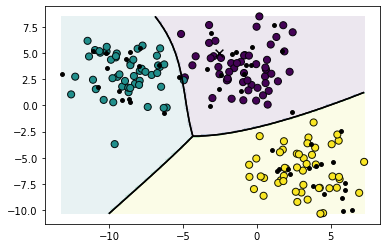

In [33]:
# Plots boundary and cost. Do not modify this cell!
plot_boundary(predict, predict_proba,
              w,X_train,y_train,X_test,y_test,
              poly=ps,scaler=sc,
              xlim=(X[:,0].min(), X[:,0].max()),
              ylim=(X[:,1].min(), X[:,1].max()))

In [34]:
# Computes metrics. Do not modify this cell!
compute_metrics(predict,w,X_train,y_train,X_test,y_test)

Training Metrics:
Accuracy:  0.99
F1 Score:  0.99
Recall:  0.99
Precision:  0.99

Test Metrics:
Accuracy:  0.98
F1 Score:  0.98
Recall:  0.98
Precision:  0.98
